Epoch 1/100


c:\Users\motyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


638/638 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2063 - precision: 0.9149 - val_loss: 0.1274 - val_precision: 0.9427
Epoch 2/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1267 - precision: 0.9411 - val_loss: 0.1181 - val_precision: 0.9436
Epoch 3/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1173 - precision: 0.9448 - val_loss: 0.1158 - val_precision: 0.9444
Epoch 4/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1177 - precision: 0.9432 - val_loss: 0.1132 - val_precision: 0.9460
Epoch 5/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1132 - precision: 0.9451 - val_loss: 0.1105 - val_precision: 0.9490
Epoch 6/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1118 - precision: 0.9471 - val_loss: 0.1088 - val_precision: 0.9491
Epoch 7/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1088 - precision: 0.9486 - val_loss: 0.1085 - val_precision: 0.9487
Epoch 8/100
638/638 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1088 - precision: 0.9485 - val_l

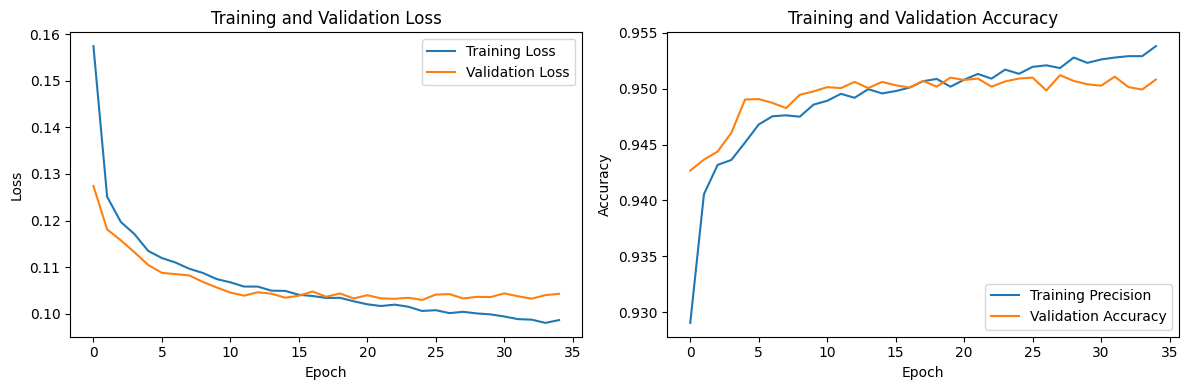

In [9]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# 1. Загрузка и предобработка данных
data = pd.read_csv('csgo_filtred.csv')
X = data.drop(axis=1, columns=['bomb_planted'])
y = data['bomb_planted']
X['map'] = X['map'].str.strip().str.lower()
mapping = {
    'de_inferno': 1,
    'de_dust2': 2,
    'de_nuke': 3,
    'de_mirage': 4,
    'de_overpass': 5,
    'de_train': 6,
    'de_vertigo': 7,
    'unknown': 8,
    'de_cache': 9
}

X['map'] = X['map'].map(mapping)
X['map'].value_counts()

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# Стандартизация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

num_classes = 2
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# 2. Определение модели
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(20,)),  # Входной слой + первый скрытый
    tf.keras.layers.Dropout(0.1),                                     # Dropout для регуляризации
    tf.keras.layers.Dense(64, activation='relu'),                     # Второй скрытый слой
    tf.keras.layers.Dropout(0.1),                                     # Dropout
    tf.keras.layers.Dense(num_classes, activation='softmax')          # Выходной слой
])

# 3. Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['precision'])

# 4. Ранняя остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 5. Обучение модели
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

# 6. Оценка модели
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'\nTest accuracy: {test_accuracy:.4f}')

# Вычисление F1-Score
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print(f'Test F1-Score: {f1:.4f}')

# 7. Визуализация результатов
plt.figure(figsize=(12, 4))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
model.save('models/nn_model_classification.h5')